## Classification

Importing libararies

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet50  
import torch.nn as nn
import torch.optim as optim


Apply Preprocessing

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='/kaggle/input/ddddddddddddddd/Oral-Implant-image', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


# Resnet50 

In [5]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)  # 5 classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Training

In [7]:
for epoch in range(20):  # Try 10-20 epochs
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0304
Epoch 2, Loss: 0.0788
Epoch 3, Loss: 0.0842
Epoch 4, Loss: 0.0057
Epoch 5, Loss: 0.0187
Epoch 6, Loss: 0.0047
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0158
Epoch 11, Loss: 0.0002
Epoch 12, Loss: 0.0003
Epoch 13, Loss: 0.0057
Epoch 14, Loss: 0.0006
Epoch 15, Loss: 0.0001
Epoch 16, Loss: 0.0571
Epoch 17, Loss: 0.0092
Epoch 18, Loss: 0.0051
Epoch 19, Loss: 0.0003
Epoch 20, Loss: 0.0002


Model Evaluation

In [8]:
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 99.41%


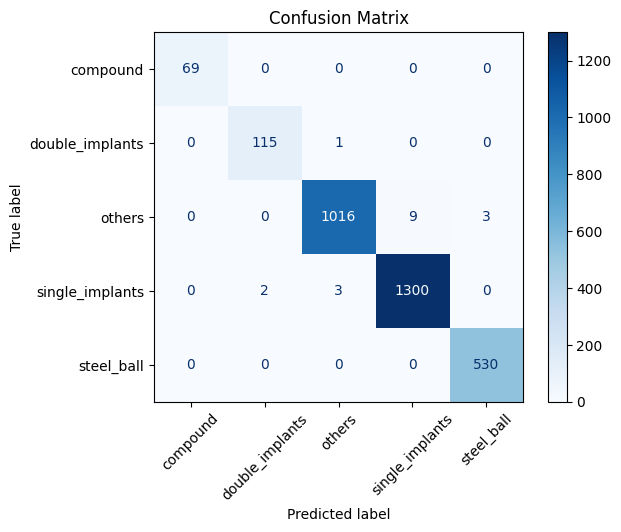

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Creating Heatmap

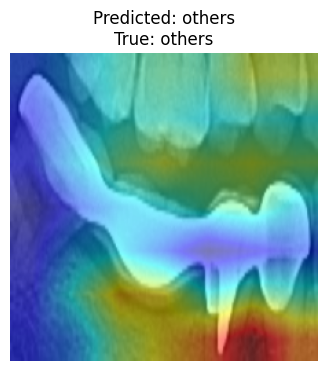

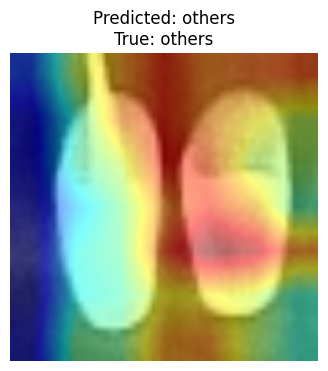

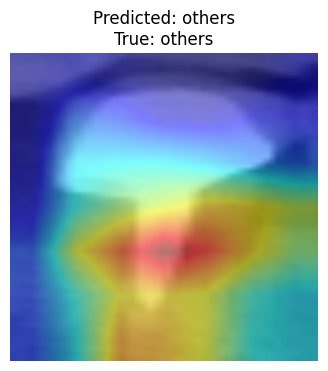

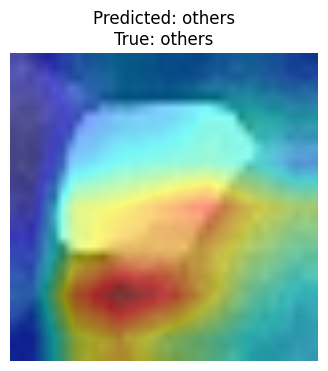

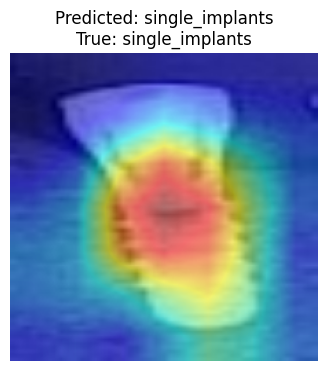

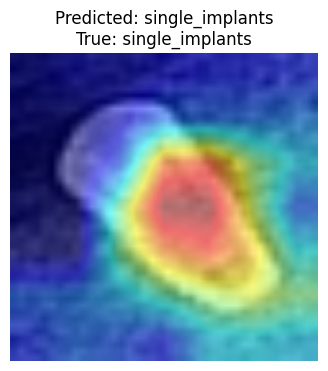

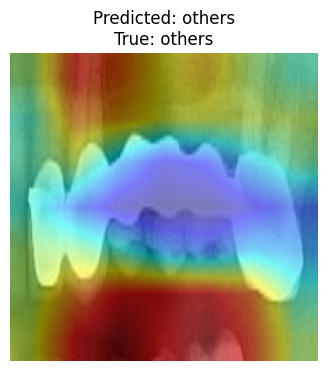

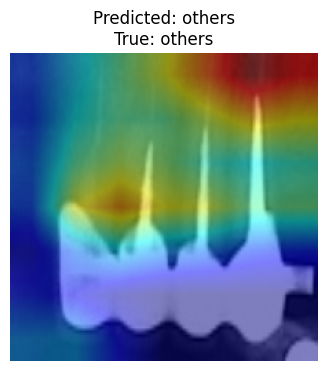

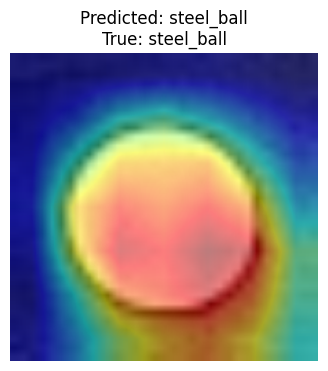

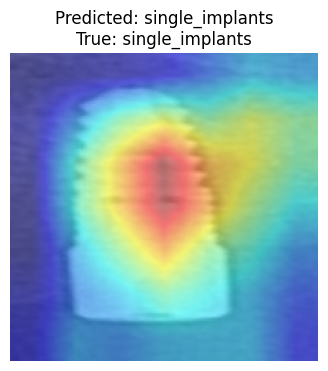

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import matplotlib.pyplot as plt

# Select the last layer of ResNet50 for Grad-CAM
target_layers = [model.layer4[-1]]

# Set model to evaluation mode
model.eval()

# Initialize Grad-CAM (no use_cuda)
with GradCAM(model=model, target_layers=target_layers) as cam:
    shown = 0
    for images, labels in val_loader:
        for i in range(len(images)):
            image = images[i].unsqueeze(0).to(device)
            label = labels[i].item()

            # Prediction
            with torch.no_grad():
                output = model(image)
                pred_class = output.argmax(dim=1).item()

            # Generate CAM
            targets = [ClassifierOutputTarget(pred_class)]
            grayscale_cam = cam(input_tensor=image, targets=targets)[0]

            # Unnormalize image
            input_tensor = image.cpu().squeeze().permute(1, 2, 0).numpy()
            input_tensor = (input_tensor * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            input_tensor = np.clip(input_tensor, 0, 1)

            # Overlay CAM
            cam_image = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)

            # Display
            plt.figure(figsize=(4, 4))
            plt.imshow(cam_image)
            plt.title(f"Predicted: {dataset.classes[pred_class]}\nTrue: {dataset.classes[label]}")
            plt.axis('off')
            plt.show()

            shown += 1
            if shown >= 10:
                break
        if shown >= 10:
            break


In [20]:
# pip install grad-cam


In [16]:
# Save the model's state_dict
torch.save(model.state_dict(), "resnet50_oral_implant.pth")


Testing saved model

/tmp/ipykernel_31/2675117098.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


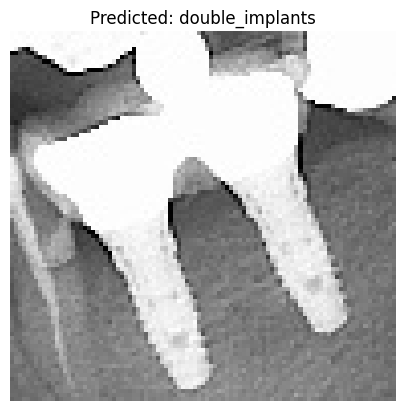

In [5]:
import torch
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------- CONFIG ----------
MODEL_PATH = "/kaggle/input/savedmodel/resnet50_oral_implant.pth"  # Make sure this path is correct
IMAGE_PATH = "/kaggle/input/ddddddddddddddd/Oral-Implant-image/double_implants/11038-B-01_4.jpg"    # Replace with actual image path
NUM_CLASSES = 5                           # Update if needed
CLASS_NAMES = ['compound', 'double_implants', 'others', 'single_implants', 'steel_balls']  # Replace with actual class names

# ---------- DEVICE ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- TRANSFORM ----------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------- LOAD MODEL ----------
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# ---------- INFERENCE FUNCTION ----------
def predict_image(image_path):
    # Load original image
    image = Image.open(image_path).convert("RGB")

    # Transform for model input
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    pred_class = CLASS_NAMES[predicted.item()]
    
    # Display ORIGINAL image (not transformed)
    plt.imshow(image)
    plt.title(f"Predicted: {pred_class}")
    plt.axis('off')
    plt.show()


# ---------- USAGE ----------
predict_image(IMAGE_PATH)


Deploying ui for resnet model

In [11]:
import torch
import numpy as np
import gradio as gr
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --- Configuration ---
MODEL_PATH = "/kaggle/input/savedmodel/resnet50_oral_implant.pth"
CLASS_NAMES = ['compound', 'double_implants', 'others', 'single_implants', 'steel_balls']
NUM_CLASSES = len(CLASS_NAMES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Load Model ---
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# --- Inference Function ---
def predict_and_explain(img: Image.Image):
    original_img = img.convert("RGB")
    input_tensor = transform(original_img).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred_class_idx = output.argmax(dim=1).item()
        pred_class_name = CLASS_NAMES[pred_class_idx]

    # Grad-CAM
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class_idx)])[0]

    # Prepare image for CAM overlay
    input_image_np = np.array(original_img.resize((224, 224))).astype(np.float32) / 255.0
    cam_image = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

    return pred_class_name, Image.fromarray(cam_image)

# --- Gradio App ---
interface = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="pil"),
    outputs=["text", "image"],
    title="Oral Implant Image Classifier with Grad-CAM",
    description="Upload an X-ray or image related to dental implants to see the prediction and visual explanation."
)

interface.launch()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/3995677542.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://75b13e6cb543c14db1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Xception model


In [18]:
import timm
# Load pretrained Xception from timm
model = timm.create_model('xception', pretrained=True)

# Replace the final classifier layer for 5 classes
model.fc = nn.Linear(model.fc.in_features, 5)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Training model

In [21]:
from tqdm import tqdm
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")


Epoch 1/20: 100%|██████████| 381/381 [03:49<00:00,  1.66it/s, loss=0.00825]


Epoch 1, Avg Loss: 0.1482


Epoch 2/20: 100%|██████████| 381/381 [03:51<00:00,  1.65it/s, loss=0.00171]


Epoch 2, Avg Loss: 0.0256


Epoch 3/20: 100%|██████████| 381/381 [03:53<00:00,  1.63it/s, loss=0.00228] 


Epoch 3, Avg Loss: 0.0167


Epoch 4/20: 100%|██████████| 381/381 [03:53<00:00,  1.63it/s, loss=0.00136] 


Epoch 4, Avg Loss: 0.0105


Epoch 5/20: 100%|██████████| 381/381 [03:53<00:00,  1.63it/s, loss=0.000644]


Epoch 5, Avg Loss: 0.0065


Epoch 6/20: 100%|██████████| 381/381 [03:52<00:00,  1.64it/s, loss=0.00168] 


Epoch 6, Avg Loss: 0.0059


Epoch 7/20: 100%|██████████| 381/381 [03:53<00:00,  1.63it/s, loss=0.00239] 


Epoch 7, Avg Loss: 0.0035


Epoch 8/20: 100%|██████████| 381/381 [03:53<00:00,  1.63it/s, loss=0.000345]


Epoch 8, Avg Loss: 0.0064


Epoch 9/20: 100%|██████████| 381/381 [03:52<00:00,  1.64it/s, loss=0.000466]


Epoch 9, Avg Loss: 0.0056


Epoch 10/20: 100%|██████████| 381/381 [03:51<00:00,  1.65it/s, loss=4.01e-5] 


Epoch 10, Avg Loss: 0.0033


Epoch 11/20: 100%|██████████| 381/381 [03:53<00:00,  1.63it/s, loss=0.00234] 


Epoch 11, Avg Loss: 0.0040


Epoch 12/20: 100%|██████████| 381/381 [03:55<00:00,  1.62it/s, loss=0.00032] 


Epoch 12, Avg Loss: 0.0070


Epoch 13/20: 100%|██████████| 381/381 [04:01<00:00,  1.58it/s, loss=6.33e-5] 


Epoch 13, Avg Loss: 0.0015


Epoch 14/20: 100%|██████████| 381/381 [04:04<00:00,  1.56it/s, loss=3.22e-5] 


Epoch 14, Avg Loss: 0.0002


Epoch 15/20: 100%|██████████| 381/381 [04:06<00:00,  1.55it/s, loss=0.00115] 


Epoch 15, Avg Loss: 0.0044


Epoch 16/20: 100%|██████████| 381/381 [04:03<00:00,  1.57it/s, loss=6.54e-5] 


Epoch 16, Avg Loss: 0.0044


Epoch 17/20: 100%|██████████| 381/381 [03:51<00:00,  1.65it/s, loss=0.0014]  


Epoch 17, Avg Loss: 0.0059


Epoch 18/20: 100%|██████████| 381/381 [03:48<00:00,  1.66it/s, loss=0.000303]


Epoch 18, Avg Loss: 0.0037


Epoch 19/20: 100%|██████████| 381/381 [03:49<00:00,  1.66it/s, loss=0.00189] 


Epoch 19, Avg Loss: 0.0054


Epoch 20/20: 100%|██████████| 381/381 [03:52<00:00,  1.64it/s, loss=0.00024] 

Epoch 20, Avg Loss: 0.0042


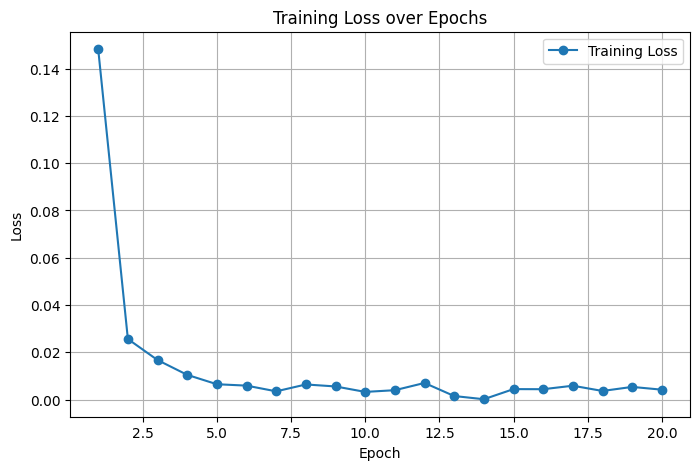

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


Evaluation

In [23]:
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 99.38%


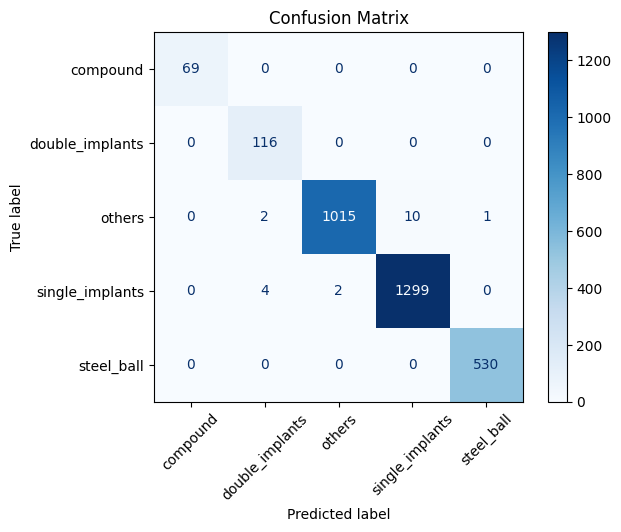

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# VisionTranformer

In [3]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = ImageFolder(root='/kaggle/input/ddddddddddddddd/Oral-Implant-image', transform=transform)

# Split into Train (70%), Val (15%), Test (15%)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [2]:
from torchvision.models import vit_b_16

# Load pretrained ViT model
model = vit_b_16(pretrained=True)

# Replace classification head
in_features = model.heads[0].in_features  # Access the first Linear layer's input features
model.heads = nn.Sequential(nn.Linear(in_features, len(dataset.classes)))  # New head

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 206MB/s]  


In [2]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [4]:
# Training Parameters
num_epochs = 10
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/10: 100%|██████████| 334/334 [07:21<00:00,  1.32s/it, loss=0.013]  


Epoch 1 -> Train Loss: 0.1293, Val Loss: 0.0647


Epoch 2/10: 100%|██████████| 334/334 [06:51<00:00,  1.23s/it, loss=0.0015] 


Epoch 2 -> Train Loss: 0.0646, Val Loss: 0.0738


Epoch 3/10: 100%|██████████| 334/334 [06:52<00:00,  1.24s/it, loss=0.0169]  


Epoch 3 -> Train Loss: 0.0519, Val Loss: 0.1415


Epoch 4/10: 100%|██████████| 334/334 [06:50<00:00,  1.23s/it, loss=0.32]    


Epoch 4 -> Train Loss: 0.0394, Val Loss: 0.0577


Epoch 5/10: 100%|██████████| 334/334 [06:51<00:00,  1.23s/it, loss=0.471]   


Epoch 5 -> Train Loss: 0.0316, Val Loss: 0.0411


Epoch 6/10: 100%|██████████| 334/334 [06:51<00:00,  1.23s/it, loss=0.0663]  


Epoch 6 -> Train Loss: 0.0414, Val Loss: 0.0823


Epoch 7/10: 100%|██████████| 334/334 [06:50<00:00,  1.23s/it, loss=0.000366]


Epoch 7 -> Train Loss: 0.0235, Val Loss: 0.0473


Epoch 8/10: 100%|██████████| 334/334 [06:52<00:00,  1.24s/it, loss=0.0147]  


Epoch 8 -> Train Loss: 0.0332, Val Loss: 0.0478


Epoch 9/10: 100%|██████████| 334/334 [06:51<00:00,  1.23s/it, loss=0.000331]


Epoch 9 -> Train Loss: 0.0228, Val Loss: 0.0390


Epoch 10/10: 100%|██████████| 334/334 [06:50<00:00,  1.23s/it, loss=0.00217] 


Epoch 10 -> Train Loss: 0.0230, Val Loss: 0.0485


In [9]:
# Save model
model_save_path = 'vit_model_oral_implant.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to vit_model_oral_implant.pth


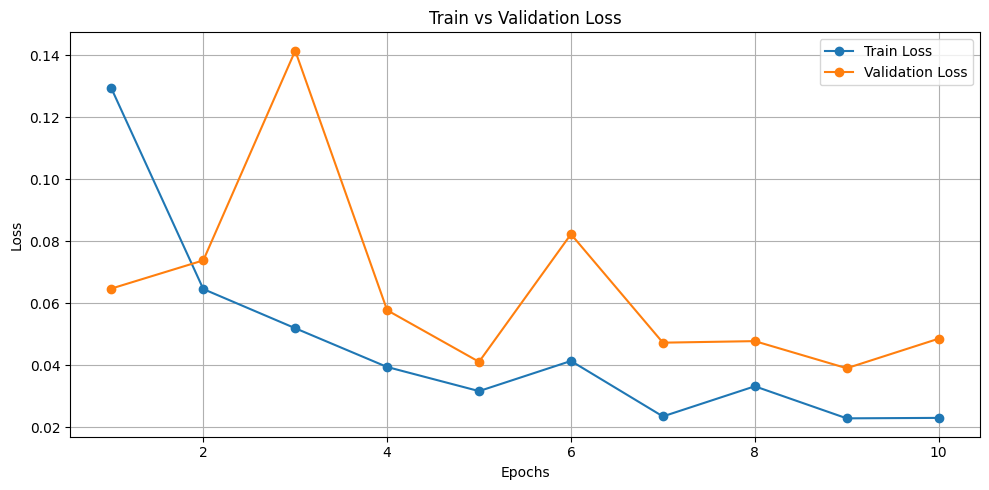

In [10]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_curve.png')
plt.show()

In [8]:
from sklearn.metrics import classification_report
import numpy as np

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


                 precision    recall  f1-score   support

       compound       0.98      0.88      0.93        57
double_implants       0.91      0.99      0.95        89
         others       0.98      0.99      0.99       775
single_implants       1.00      0.99      0.99       977
     steel_ball       1.00      0.98      0.99       388

       accuracy                           0.99      2286
      macro avg       0.97      0.97      0.97      2286
   weighted avg       0.99      0.99      0.99      2286



In [11]:
def get_last_selfattention(model, x):
    # Forward hook to extract attention
    with torch.no_grad():
        # Extract patch embeddings + positional encoding
        for blk in model.encoder.layers:
            x = blk(x)
        return x
def get_last_selfattention(model, x):
    # Forward hook to extract attention
    with torch.no_grad():
        # Extract patch embeddings + positional encoding
        for blk in model.encoder.layers:
            x = blk(x)
        return x


In [18]:
# !pip install torchcam


In [1]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

# 1. Define model same as training
model = vit_b_16(pretrained=True)

# 2. Replace head with the correct number of output classes
num_classes = 5  # Replace with your actual number if different
in_features = model.heads[0].in_features
model.heads = nn.Sequential(nn.Linear(in_features, num_classes))

# 3. Load the weights
state_dict = torch.load("/kaggle/input/savedmodel/vit_model_oral_implant.pth", map_location='cpu')
model.load_state_dict(state_dict)

# 4. Set to evaluation mode
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_90/3506673179.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [2]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = ImageFolder(root='/kaggle/input/ddddddddddddddd/Oral-Implant-image', transform=transform)

# Split into Train (70%), Val (15%), Test (15%)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [3]:
import random
from torch.utils.data import Subset

# Pick 10 random indices from the test set
random_indices = random.sample(range(len(test_dataset)), 10)

# Create a subset of those 10
test_subset = Subset(test_dataset, random_indices)

# Use a DataLoader for batch inference
test_subset_loader = DataLoader(test_subset, batch_size=1, shuffle=False)


In [4]:
!pip install -q torchcam


In [5]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [8]:
for name, module in model.named_modules():
    print(name)



conv_proj
encoder
encoder.dropout
encoder.layers
encoder.layers.encoder_layer_0
encoder.layers.encoder_layer_0.ln_1
encoder.layers.encoder_layer_0.self_attention
encoder.layers.encoder_layer_0.self_attention.out_proj
encoder.layers.encoder_layer_0.dropout
encoder.layers.encoder_layer_0.ln_2
encoder.layers.encoder_layer_0.mlp
encoder.layers.encoder_layer_0.mlp.0
encoder.layers.encoder_layer_0.mlp.1
encoder.layers.encoder_layer_0.mlp.2
encoder.layers.encoder_layer_0.mlp.3
encoder.layers.encoder_layer_0.mlp.4
encoder.layers.encoder_layer_1
encoder.layers.encoder_layer_1.ln_1
encoder.layers.encoder_layer_1.self_attention
encoder.layers.encoder_layer_1.self_attention.out_proj
encoder.layers.encoder_layer_1.dropout
encoder.layers.encoder_layer_1.ln_2
encoder.layers.encoder_layer_1.mlp
encoder.layers.encoder_layer_1.mlp.0
encoder.layers.encoder_layer_1.mlp.1
encoder.layers.encoder_layer_1.mlp.2
encoder.layers.encoder_layer_1.mlp.3
encoder.layers.encoder_layer_1.mlp.4
encoder.layers.encoder_l